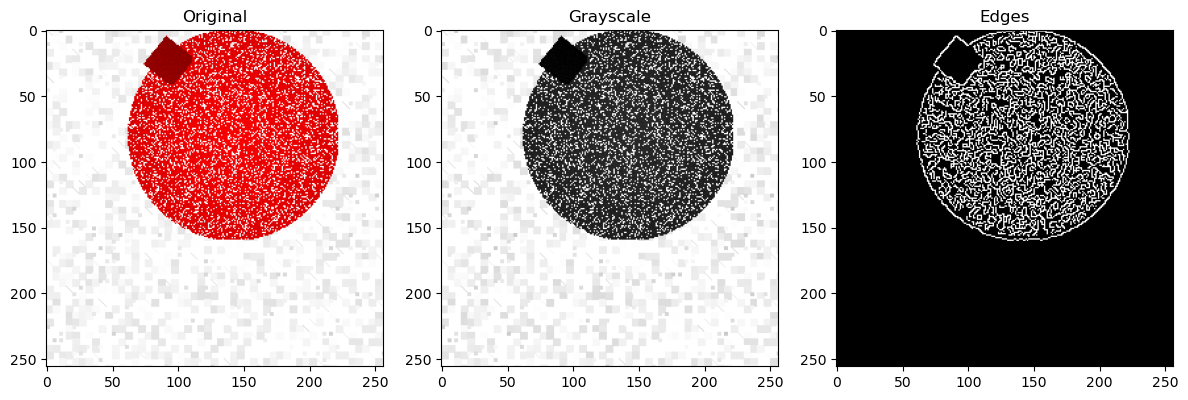

In [1]:
import cv2
import matplotlib.pyplot as plt

# Load image
image = cv2.imread('../data/test_dataset/img_0.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Edge Detection using Canny
edges = cv2.Canny(blurred, threshold1=0, threshold2=150)

# Visualize
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(image_rgb)

plt.subplot(1, 3, 2)
plt.title("Grayscale")
plt.imshow(gray, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Edges")
plt.imshow(edges, cmap='gray')

plt.tight_layout()
plt.show()


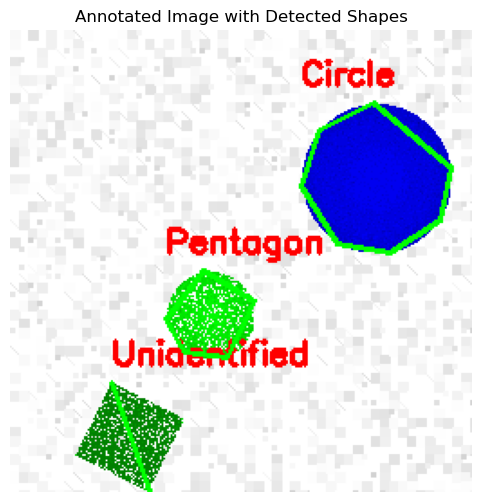


Summary:
Total shapes detected: 3
- Unidentified: 1
- Pentagon: 1
- Circle: 1


In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Load image
image = cv2.imread('../data/train_dataset/img_560.png')
if image is None:
    raise FileNotFoundError("Check the image path.")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Preprocessing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# For storing shape counts
shape_counts = defaultdict(int)
output = image_rgb.copy()

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 200:
        continue

    # Approximate shape
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
    x, y, w, h = cv2.boundingRect(approx)

    num_sides = len(approx)
    shape = "Unidentified"

    if num_sides == 3:
        shape = "Triangle"
    elif num_sides == 4:
        aspect_ratio = w / float(h)
        shape = "Square" if 0.95 < aspect_ratio < 1.05 else "Rectangle"
    elif num_sides == 5:
        shape = "Pentagon"
    elif num_sides > 5:
        shape = "Circle"

    shape_counts[shape] += 1

    # Draw and label the shape
    cv2.drawContours(output, [approx], -1, (0, 255, 0), 2)
    cv2.putText(output, shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Display results
plt.figure(figsize=(10, 6))
plt.imshow(output)
plt.title("Annotated Image with Detected Shapes")
plt.axis('off')
plt.show()

# Print shape summary
print("\nSummary:")
total_shapes = sum(shape_counts.values())
print(f"Total shapes detected: {total_shapes}")
for shape, count in shape_counts.items():
    print(f"- {shape}: {count}")


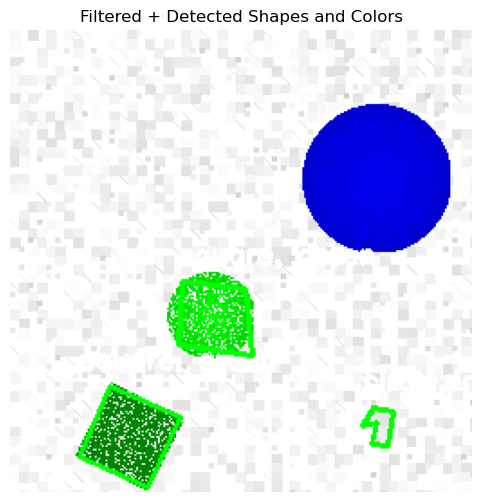

Predicted (shape, color) pairs: [('square', 'green'), ('circle', 'red')]


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def get_dominant_color(masked_roi, mask):
    hsv = cv2.cvtColor(masked_roi, cv2.COLOR_RGB2HSV)
    
    # Erode the mask to avoid picking up boundary pixels
    kernel = np.ones((5, 5), np.uint8)
    eroded_mask = cv2.erode(mask, kernel, iterations=1)
    
    pixels = hsv[eroded_mask > 0]
    if len(pixels) == 0:
        return 'unknown'

    dominant_hue = Counter(pixels[:, 0]).most_common(1)[0][0]

    if dominant_hue < 10 or dominant_hue > 160:
        return 'red'
    elif 40 < dominant_hue <= 85:
        return 'green'
    elif 90 < dominant_hue <= 130:
        return 'blue'
    else:
        return 'unknown'

def detect_shapes_and_colors(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original = image_rgb.copy()

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # ✨ Noise-tolerant filtering
    blurred = cv2.medianBlur(gray, 5)  # great for grid or salt-and-pepper noise
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel)

    # Canny on cleaned image
    edges = cv2.Canny(cleaned, 50, 150)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shape_color_set = set()

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 200:
            continue

        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
        x, y, w, h = cv2.boundingRect(approx)
        num_sides = len(approx)

        shape = None
        if num_sides == 3:
            shape = "triangle"
        elif num_sides == 4:
            aspect_ratio = w / float(h)
            if 0.95 < aspect_ratio < 1.05:
                shape = "square"
        elif num_sides >= 6:
            shape = "circle"

        if shape is None:
            continue

        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.drawContours(mask, [cnt], -1, 255, -1)

        masked_roi = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
        roi_cropped = masked_roi[y:y+h, x:x+w]
        mask_cropped = mask[y:y+h, x:x+w]

        color = get_dominant_color(roi_cropped, mask_cropped)

        if shape and color in ['red', 'green', 'blue']:
            shape_color_set.add((shape, color))

            # Draw label and contour
            label = f"{shape}, {color}"
            cv2.putText(original, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
            cv2.drawContours(original, [approx], -1, (0, 255, 0), 2)

    # Show result
    plt.figure(figsize=(10, 6))
    plt.imshow(original)
    plt.title("Filtered + Detected Shapes and Colors")
    plt.axis('off')
    plt.show()

    return list(shape_color_set)


result = detect_shapes_and_colors('../data/train_dataset/img_560.png')
print("Predicted (shape, color) pairs:", result)


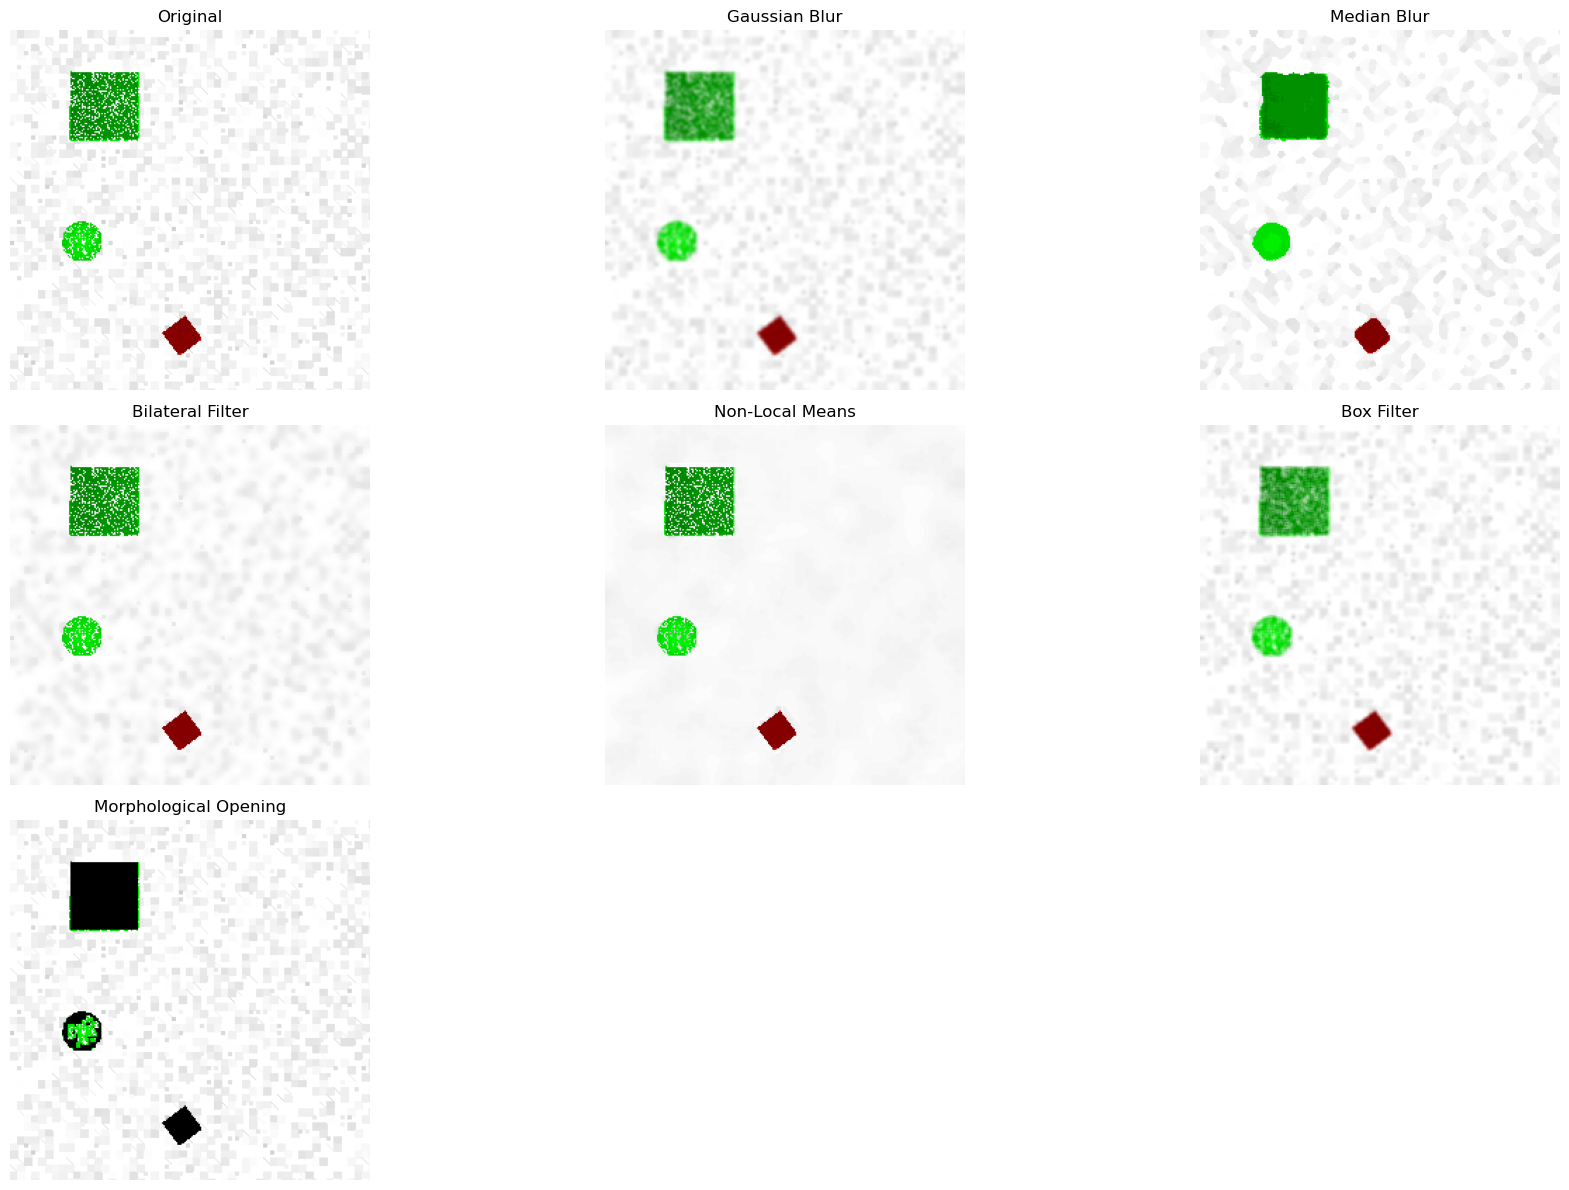

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the noisy image
image_path = "../data/train_dataset/img_105.png"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply various filtering techniques
# 1. Gaussian Blur
gaussian = cv2.GaussianBlur(image_rgb, (5, 5), 0)

# 2. Median Blur
median = cv2.medianBlur(image_rgb, 7)

# 3. Bilateral Filter
bilateral = cv2.bilateralFilter(image_rgb, 9, 75, 75)

# 4. Non-local Means Denoising
nlm = cv2.fastNlMeansDenoisingColored(image_rgb, None, 10, 10, 7, 21)

# 5. Box Filter
box = cv2.blur(image_rgb, (3, 3))

# 6. Morphological Opening
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
kernel = np.ones((3, 3), np.uint8)
opening_mask = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
opening = cv2.bitwise_and(image_rgb, image_rgb, mask=opening_mask)

# Plot all
filters = {
    "Original": image_rgb,
    "Gaussian Blur": gaussian,
    "Median Blur": median,
    "Bilateral Filter": bilateral,
    "Non-Local Means": nlm,
    "Box Filter": box,
    "Morphological Opening": opening
}

plt.figure(figsize=(18, 12))
for i, (title, img) in enumerate(filters.items(), 1):
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()


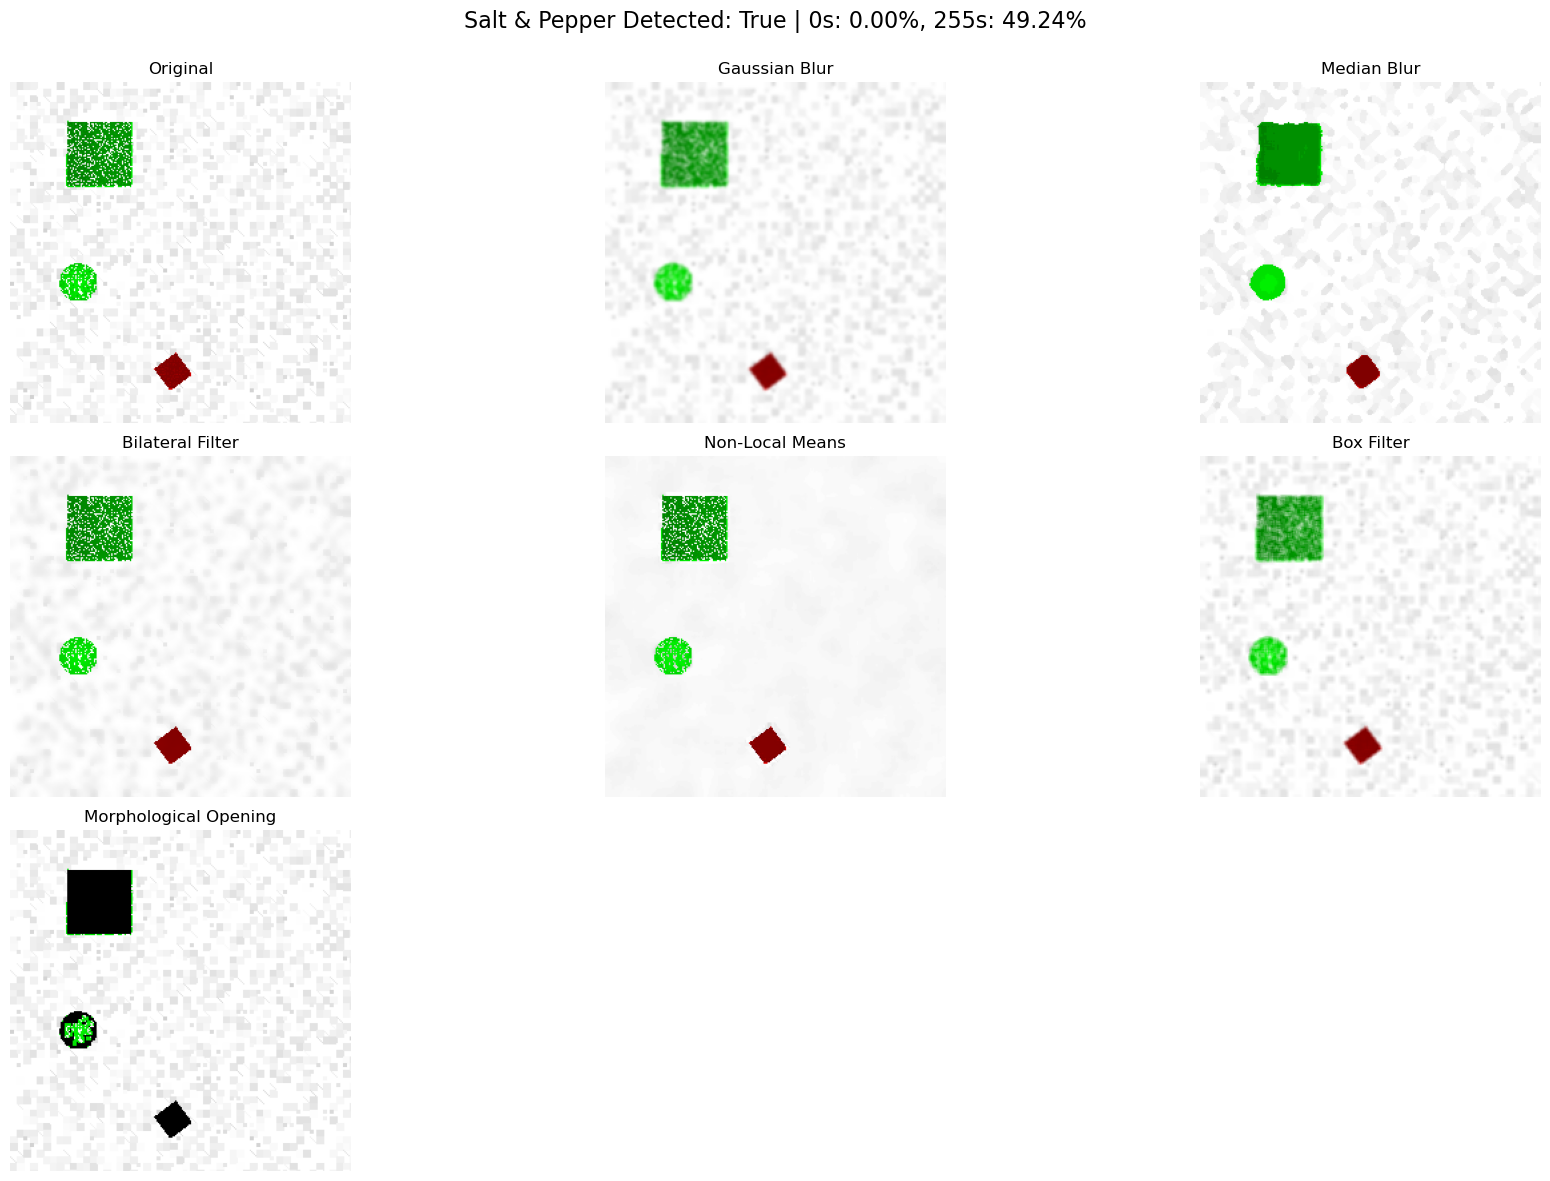

In [61]:
# Correcting the image path to match the user's original path
image_path = "../data/train_dataset/img_105.png"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def is_salt_and_pepper(image_gray, threshold=0.01):
    """Estimate if the image has salt-and-pepper noise by analyzing pixel intensities."""
    total_pixels = image_gray.size
    num_zeros = np.sum(image_gray == 0)
    num_ones = np.sum(image_gray == 255)
    
    fraction_zeros = num_zeros / total_pixels
    fraction_ones = num_ones / total_pixels

    is_sp_noise = (fraction_zeros > threshold or fraction_ones > threshold)
    
    return is_sp_noise, fraction_zeros, fraction_ones

# Apply various filtering techniques
gaussian = cv2.GaussianBlur(image_rgb, (5, 5), 0)
median = cv2.medianBlur(image_rgb, 7)
bilateral = cv2.bilateralFilter(image_rgb, 9, 75, 75)
nlm = cv2.fastNlMeansDenoisingColored(image_rgb, None, 10, 10, 7, 21)
box = cv2.blur(image_rgb, (3, 3))

# Morphological Opening
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
kernel = np.ones((3, 3), np.uint8)
opening_mask = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
opening = cv2.bitwise_and(image_rgb, image_rgb, mask=opening_mask)

# Check for salt-and-pepper noise
is_sp_noise, fraction_zeros, fraction_ones = is_salt_and_pepper(gray)

# Plot all
filters = {
    "Original": image_rgb,
    "Gaussian Blur": gaussian,
    "Median Blur": median,
    "Bilateral Filter": bilateral,
    "Non-Local Means": nlm,
    "Box Filter": box,
    "Morphological Opening": opening
}

plt.figure(figsize=(18, 12))
for i, (title, img) in enumerate(filters.items(), 1):
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.suptitle(f"Salt & Pepper Detected: {is_sp_noise} | 0s: {fraction_zeros:.2%}, 255s: {fraction_ones:.2%}", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()


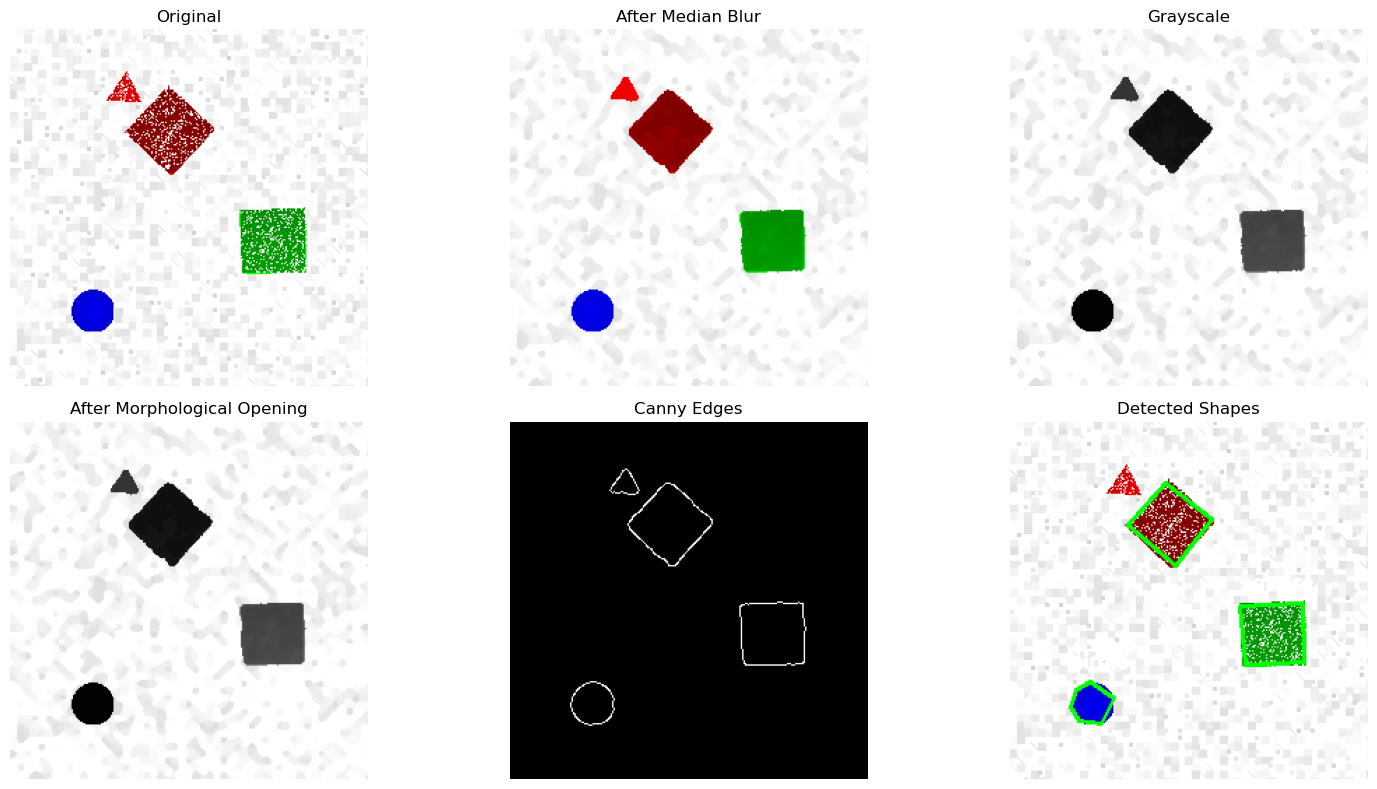

In [153]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step-by-step pipeline function
def shape_detection_pipeline(image_path):
    steps = {}

    # Step 1: Load image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    steps["Original"] = image_rgb.copy()

    # Step 2: Median Blur for Salt & Pepper Noise
    denoised = cv2.medianBlur(image_rgb, 7)
    steps["After Median Blur"] = denoised.copy()

    # Step 3: Convert to grayscale
    gray = cv2.cvtColor(denoised, cv2.COLOR_RGB2GRAY)
    steps["Grayscale"] = gray.copy()

    # Step 4: Morphological Opening to clean residual noise
    kernel = np.ones((3, 3), np.uint8)
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    steps["After Morphological Opening"] = opened.copy()

    # Step 5: Canny Edge Detection
    edges = cv2.Canny(opened, 30, 200)
    steps["Canny Edges"] = edges.copy()

    # Step 6: Contour Detection and Shape Drawing
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    annotated = image_rgb.copy()

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 200:
            continue

        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
        x, y, w, h = cv2.boundingRect(approx)
        num_sides = len(approx)

        shape = None
        if num_sides == 3:
            shape = "triangle"
        elif num_sides == 4:
            aspect_ratio = w / float(h)
            if 0.95 < aspect_ratio < 1.05:
                shape = "square"
        elif num_sides > 5:
            shape = "circle"

        if shape:
            cv2.putText(annotated, shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
            cv2.drawContours(annotated, [approx], -1, (0, 255, 0), 2)

    steps["Detected Shapes"] = annotated.copy()

    # Plotting each step
    num_steps = len(steps)
    plt.figure(figsize=(16, 8))
    for i, (title, img) in enumerate(steps.items(), 1):
        plt.subplot(2, (num_steps + 1) // 2, i)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Run pipeline on a sample image from previous uploads
shape_detection_pipeline('../data/train_dataset/img_4999.png')


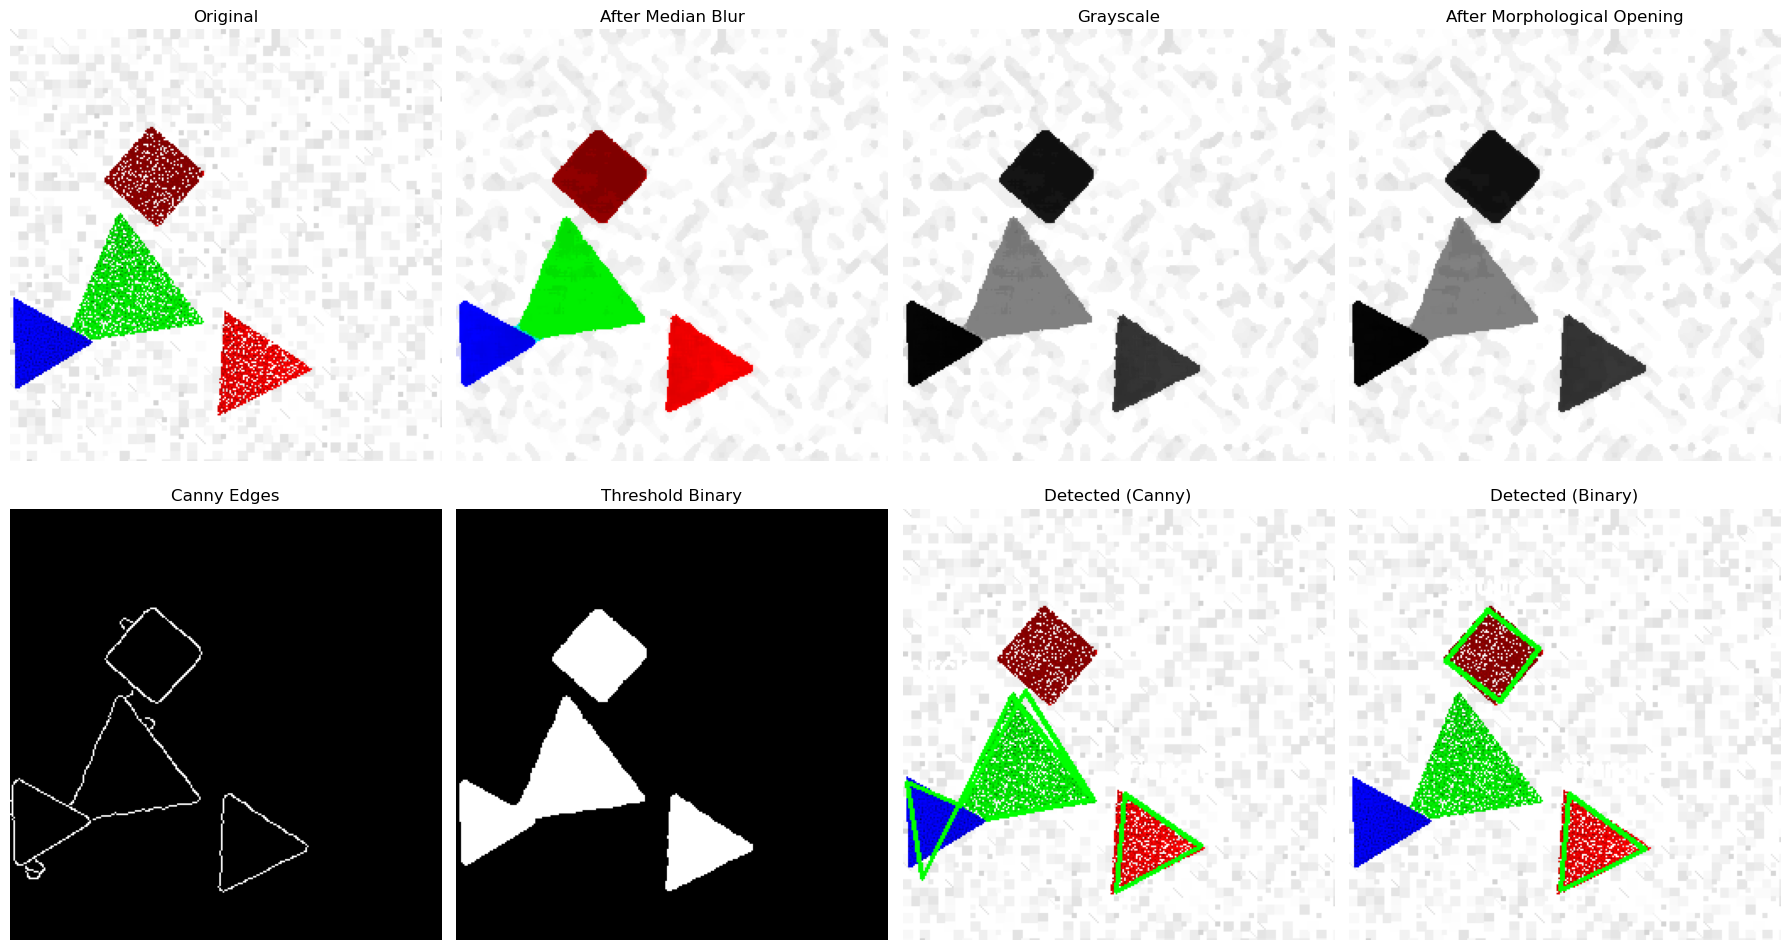

In [195]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def shape_detection_pipeline(image_path):
    steps = {}

    # Step 1: Load image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    steps["Original"] = image_rgb.copy()

    # Step 2: Median Blur for Salt & Pepper Noise
    denoised = cv2.medianBlur(image_rgb, 7)
    steps["After Median Blur"] = denoised.copy()

    # Step 3: Convert to grayscale
    gray = cv2.cvtColor(denoised, cv2.COLOR_RGB2GRAY)
    steps["Grayscale"] = gray.copy()

    # Step 4: Morphological Opening
    kernel = np.ones((3, 3), np.uint8)
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    steps["After Morphological Opening"] = opened.copy()

    # Step 5a: Canny Edge Detection
    edges = cv2.Canny(opened, 30, 200)
    steps["Canny Edges"] = edges.copy()

    # Step 5b: Binary Thresholding (alternative method)
    _, binary_thresh = cv2.threshold(opened, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    steps["Threshold Binary"] = binary_thresh.copy()

    # Step 6a: Contour Detection from Canny edges
    contours_canny, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    canny_annotated = image_rgb.copy()

    for cnt in contours_canny:
        if cv2.contourArea(cnt) < 200:
            continue
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
        x, y, w, h = cv2.boundingRect(approx)
        num_sides = len(approx)

        shape = None
        if num_sides == 3:
            shape = "triangle"
        elif num_sides == 4 and 0.95 < w / float(h) < 1.05:
            shape = "square"
        elif num_sides > 5:
            shape = "circle"

        if shape:
            cv2.putText(canny_annotated, shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
            cv2.drawContours(canny_annotated, [approx], -1, (0, 255, 0), 2)

    steps["Detected (Canny)"] = canny_annotated.copy()

    # Step 6b: Contour Detection from Binary
    contours_binary, _ = cv2.findContours(binary_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    binary_annotated = image_rgb.copy()

    for cnt in contours_binary:
        if cv2.contourArea(cnt) < 200:
            continue
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
        x, y, w, h = cv2.boundingRect(approx)
        num_sides = len(approx)

        shape = None
        if num_sides == 3:
            shape = "triangle"
        elif num_sides == 4 and 0.95 < w / float(h) < 1.05:
            shape = "square"
        elif num_sides > 5:
            shape = "circle"

        if shape:
            cv2.putText(binary_annotated, shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
            cv2.drawContours(binary_annotated, [approx], -1, (0, 255, 0), 2)

    steps["Detected (Binary)"] = binary_annotated.copy()

    # Plot all steps
    num_steps = len(steps)
    plt.figure(figsize=(18, 10))
    for i, (title, img) in enumerate(steps.items(), 1):
        plt.subplot(2, (num_steps + 1) // 2, i)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Run the pipeline
shape_detection_pipeline('../data/train_dataset/img_8.png')


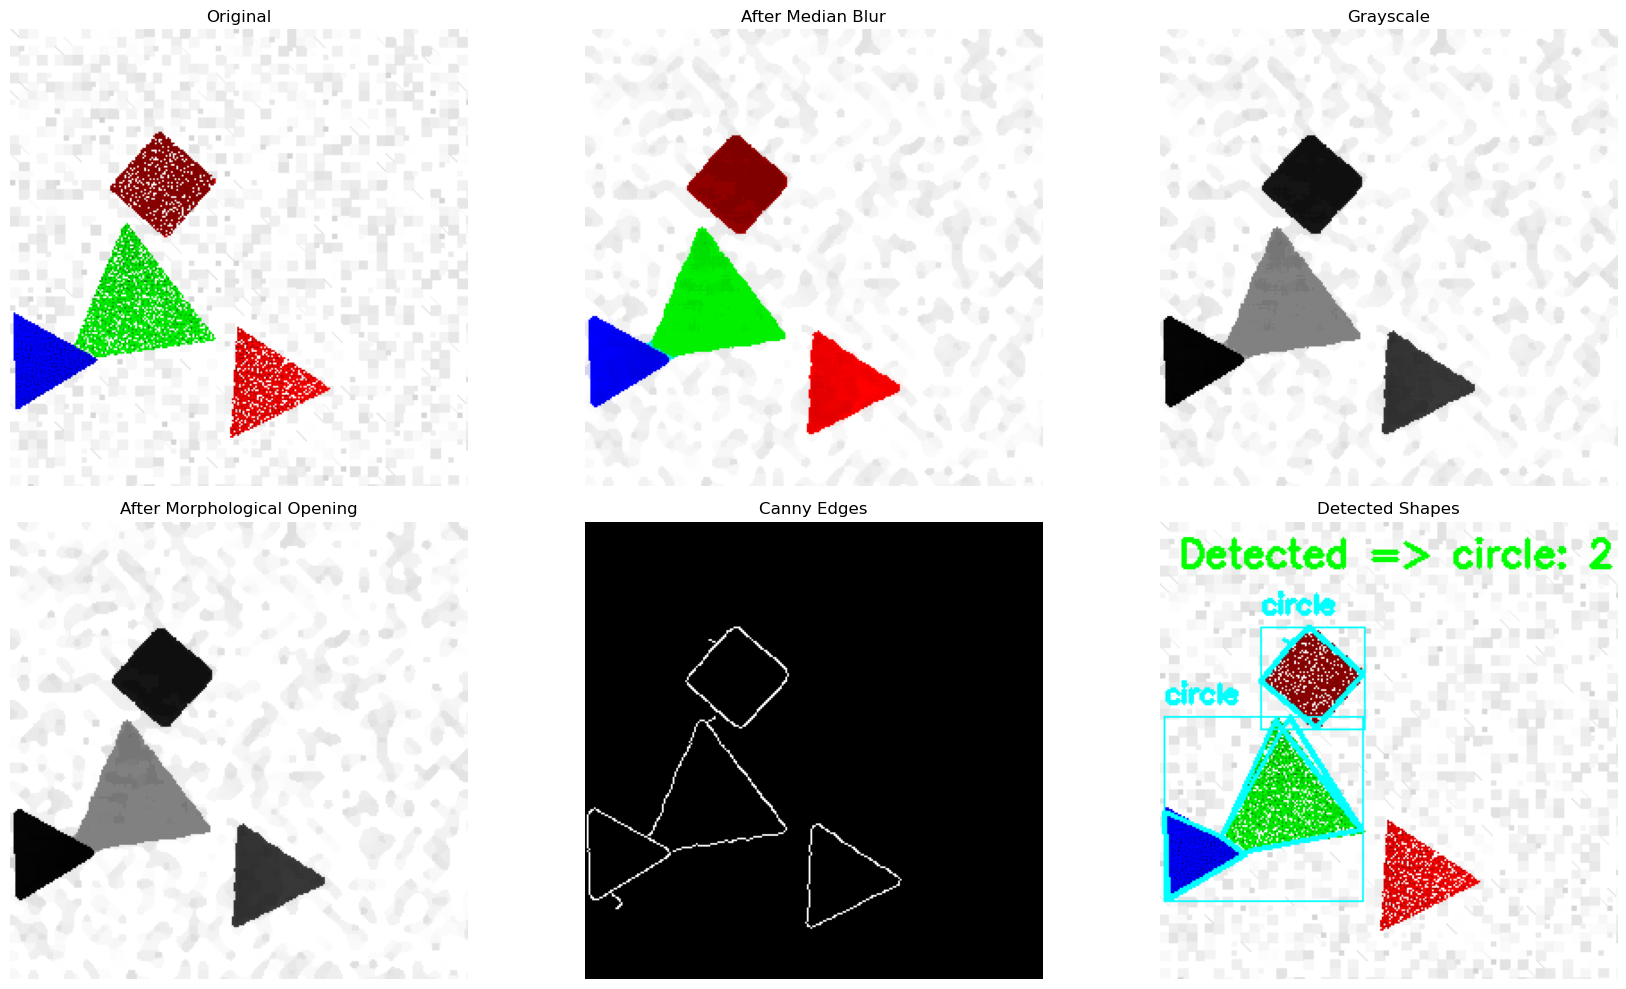

In [193]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def shape_detection_pipeline(image_path):
    steps = {}

    # Load and convert to RGB
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    steps["Original"] = image_rgb.copy()

    # Median blur
    denoised = cv2.medianBlur(image_rgb, 7)
    steps["After Median Blur"] = denoised.copy()

    # Grayscale
    gray = cv2.cvtColor(denoised, cv2.COLOR_RGB2GRAY)
    steps["Grayscale"] = gray.copy()

    # Morphological opening
    kernel = np.ones((3, 3), np.uint8)
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    steps["After Morphological Opening"] = opened.copy()

    # Canny edges
    edges = cv2.Canny(opened, 100, 200)
    steps["Canny Edges"] = edges.copy()

    # Contours from Canny
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    annotated = image_rgb.copy()

    # Counters
    shape_counts = {"triangle": 0, "square": 0, "circle": 0}

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 80:  # lowered threshold to detect smaller shapes
            continue

        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)  # finer epsilon
        x, y, w, h = cv2.boundingRect(approx)
        num_sides = len(approx)

        shape = None
        color = (255, 255, 255)

        if num_sides == 3:
            shape = "triangle"
            color = (0, 0, 255)  # red
        elif num_sides == 4:
            aspect_ratio = w / float(h)
            if 0.90 < aspect_ratio < 1.10:
                shape = "square"
                color = (0, 255, 0)  # green
        elif num_sides > 5:
            shape = "circle"
            color = (0, 255, 255)  # yellow

        if shape:
            shape_counts[shape] += 1
            cv2.drawContours(annotated, [approx], -1, color, 2)
            cv2.rectangle(annotated, (x, y), (x + w, y + h), color, 1)
            cv2.putText(annotated, shape, (x, y - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Add shape counts on final image
    summary = ', '.join(f'{k}: {v}' for k, v in shape_counts.items() if v > 0)
    cv2.putText(annotated, f"Detected => {summary}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    steps["Detected Shapes"] = annotated.copy()

    # Plot all steps
    num_steps = len(steps)
    plt.figure(figsize=(18, 10))
    for i, (title, img) in enumerate(steps.items(), 1):
        plt.subplot(2, (num_steps + 1) // 2, i)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


shape_detection_pipeline('../data/train_dataset/img_8.png')


[Canny] Detected shapes: {'triangle': 2, 'square': 0, 'circle': 1}
[Binary] Detected shapes: {'triangle': 2, 'square': 0, 'circle': 1}


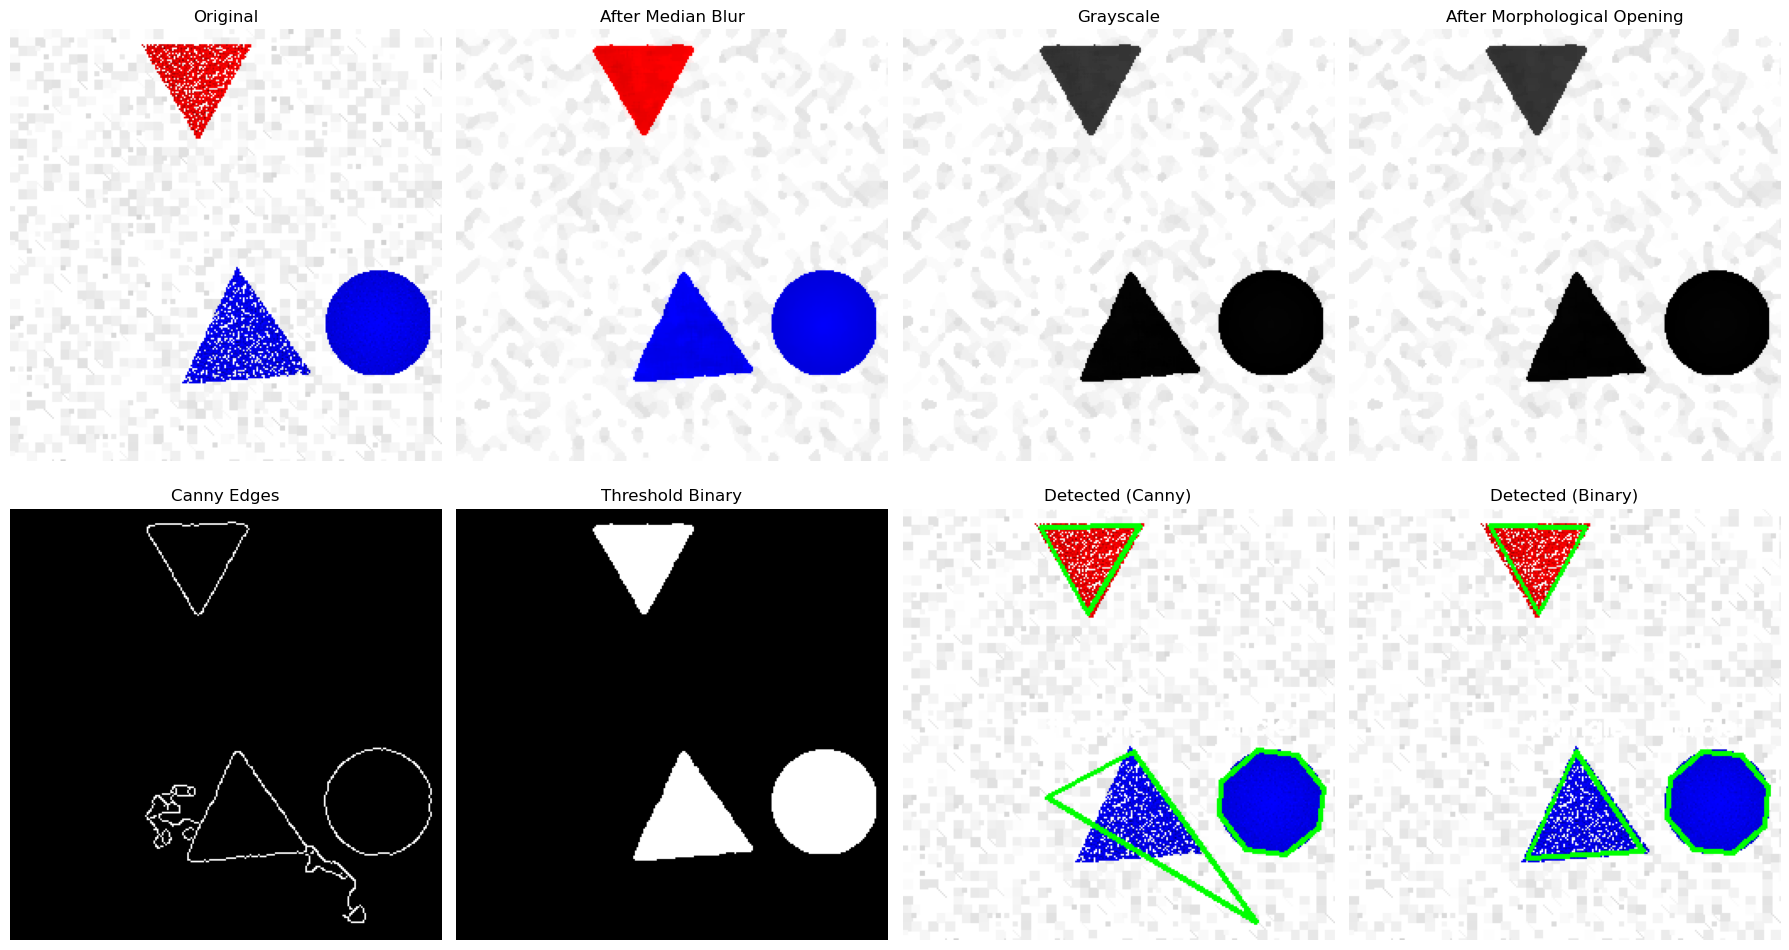

In [267]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def shape_detection_pipeline(image_path):
    steps = {}

    # Step 1: Load image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    steps["Original"] = image_rgb.copy()

    # Step 2: Median Blur for Salt & Pepper Noise
    denoised = cv2.medianBlur(image_rgb, 7)
    steps["After Median Blur"] = denoised.copy()

    # Step 3: Convert to grayscale
    gray = cv2.cvtColor(denoised, cv2.COLOR_RGB2GRAY)
    steps["Grayscale"] = gray.copy()

    # Step 4: Morphological Opening
    kernel = np.ones((3, 3), np.uint8)
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    steps["After Morphological Opening"] = opened.copy()

    # Step 5a: Canny Edge Detection
    edges = cv2.Canny(opened, 30, 200)
    steps["Canny Edges"] = edges.copy()

    # Step 5b: Binary Thresholding (alternative method)
    _, binary_thresh = cv2.threshold(opened, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    steps["Threshold Binary"] = binary_thresh.copy()

    # Common function for shape detection
    def detect_shapes(contours, annotated_img, method_name):
        count_shapes = {"triangle": 0, "square": 0, "circle": 0}
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < 200:
                continue
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
            x, y, w, h = cv2.boundingRect(approx)
            num_sides = len(approx)
            circularity = 4 * np.pi * area / (peri * peri)

            shape = None
            if num_sides == 3:
                shape = "triangle"
            elif num_sides == 4:
                aspect_ratio = w / float(h)
                if 0.90 < aspect_ratio < 1.10:
                    shape = "square"
            elif circularity > 0.8:
                shape = "circle"

            if shape:
                count_shapes[shape] += 1
                cv2.putText(annotated_img, shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                cv2.drawContours(annotated_img, [approx], -1, (0, 255, 0), 2)

        print(f"[{method_name}] Detected shapes:", count_shapes)
        return annotated_img

    # Step 6a: Contour Detection from Canny
    contours_canny, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    canny_annotated = detect_shapes(contours_canny, image_rgb.copy(), "Canny")
    steps["Detected (Canny)"] = canny_annotated.copy()

    # Step 6b: Contour Detection from Threshold Binary
    contours_binary, _ = cv2.findContours(binary_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    binary_annotated = detect_shapes(contours_binary, image_rgb.copy(), "Binary")
    steps["Detected (Binary)"] = binary_annotated.copy()

    # Plot all steps
    num_steps = len(steps)
    plt.figure(figsize=(18, 10))
    for i, (title, img) in enumerate(steps.items(), 1):
        plt.subplot(2, (num_steps + 1) // 2, i)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Run the pipeline
shape_detection_pipeline('../data/train_dataset/img_3988.png')


[Canny] Detected shapes: {'triangle': 0, 'square': 2, 'circle': 1}
[Binary] Detected shapes: {'triangle': 0, 'square': 2, 'circle': 1}

Predicted (shape, color) pairs: [('circle', 'blue'), ('square', 'green'), ('square', 'red')]


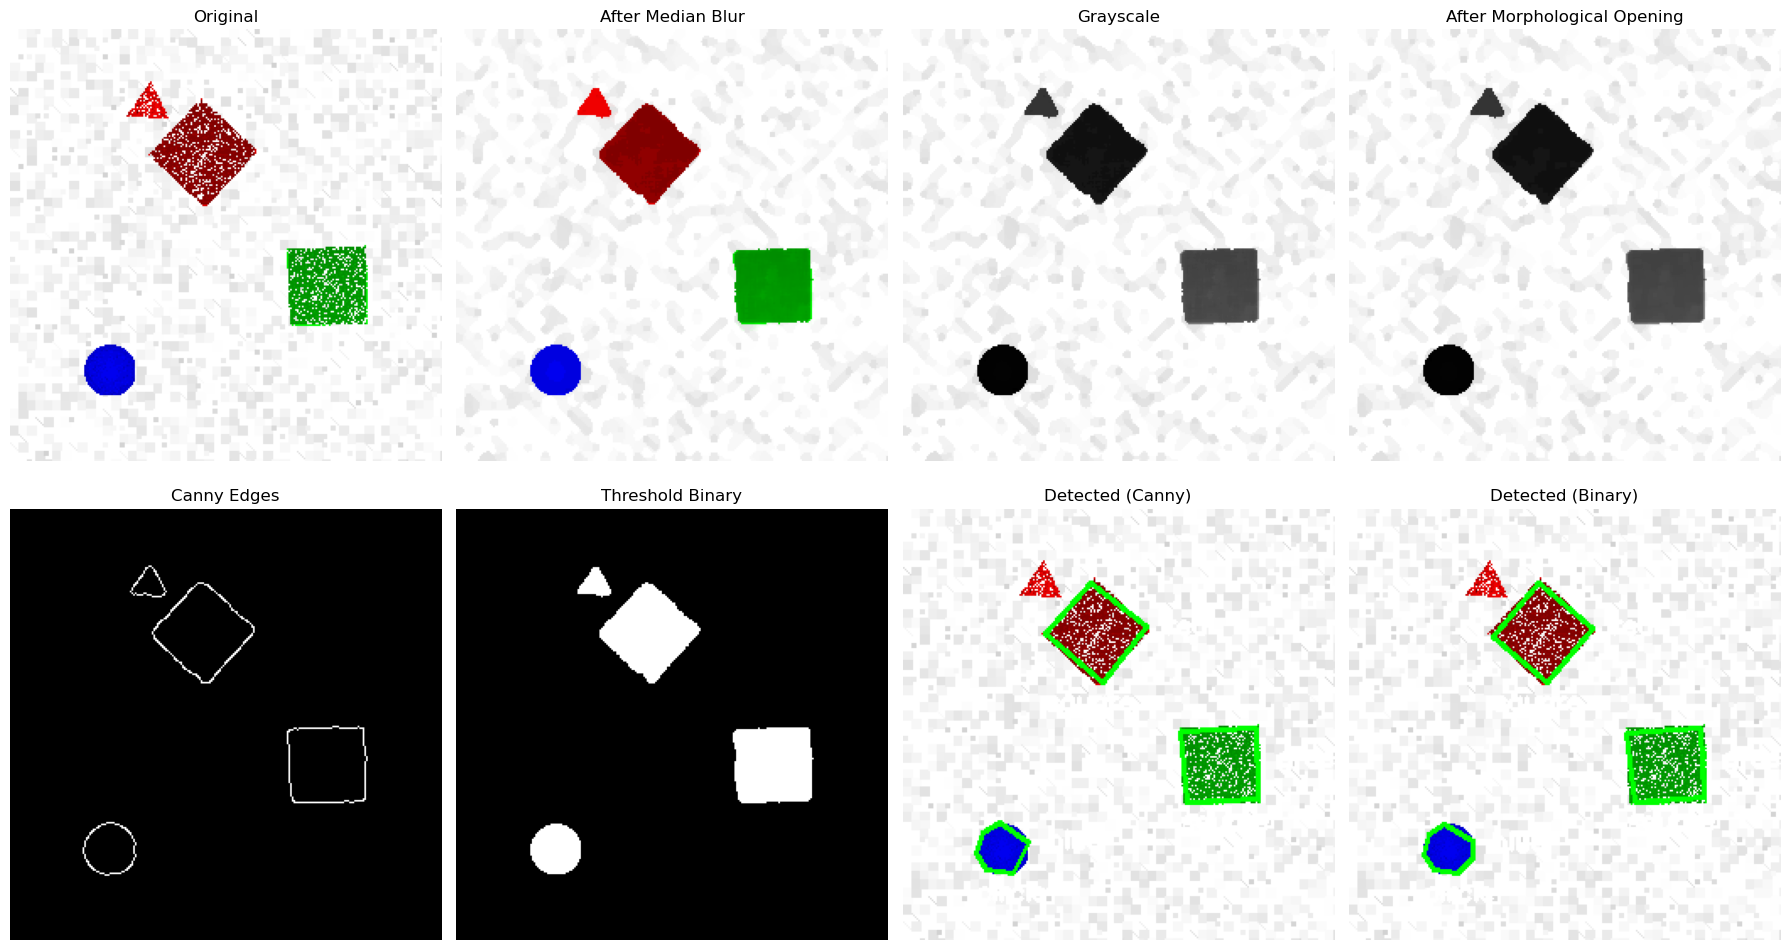

In [295]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def shape_detection_pipeline(image_path):
    steps = {}

    # Step 1: Load image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    steps["Original"] = image_rgb.copy()

    # Step 2: Median Blur for Salt & Pepper Noise
    denoised = cv2.medianBlur(image_rgb, 7)
    steps["After Median Blur"] = denoised.copy()

    # Step 3: Convert to grayscale
    gray = cv2.cvtColor(denoised, cv2.COLOR_RGB2GRAY)
    steps["Grayscale"] = gray.copy()

    # Step 4: Morphological Opening
    kernel = np.ones((3, 3), np.uint8)
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    steps["After Morphological Opening"] = opened.copy()

    # Step 5a: Canny Edge Detection
    edges = cv2.Canny(opened, 30, 200)
    steps["Canny Edges"] = edges.copy()

    # Step 5b: Binary Thresholding
    _, binary_thresh = cv2.threshold(opened, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    steps["Threshold Binary"] = binary_thresh.copy()

    # Color classification helper
    def classify_color(roi_rgb):
        avg_color = np.mean(roi_rgb.reshape(-1, 3), axis=0)  # (R, G, B)
        r, g, b = avg_color
        if r > g and r > b:
            return "red"
        elif g > r and g > b:
            return "green"
        elif b > r and b > g:
            return "blue"
        else:
            return "unknown"

    # Shared shape+color detection logic
    def detect_shapes(contours, annotated_img, method_name):
        count_shapes = {"triangle": 0, "square": 0, "circle": 0}
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < 200:
                continue
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
            x, y, w, h = cv2.boundingRect(approx)
            num_sides = len(approx)
            circularity = 4 * np.pi * area / (peri * peri)

            shape = None
            if num_sides == 3:
                shape = "triangle"
            elif num_sides == 4:
                aspect_ratio = w / float(h)
                if 0.90 < aspect_ratio < 1.10:
                    shape = "square"
            elif circularity > 0.8:
                shape = "circle"

            if shape:
                count_shapes[shape] += 1
                roi = annotated_img[y:y+h, x:x+w]
                color = classify_color(roi)

                # Draw results
                cv2.drawContours(annotated_img, [approx], -1, (0, 255, 0), 2)
                cv2.putText(annotated_img, shape, (x, y + h + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                cv2.putText(annotated_img, color, (x + w + 10, y + h // 2),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        print(f"[{method_name}] Detected shapes:", count_shapes)
        return annotated_img

    # Step 6a: From Canny
    contours_canny, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    canny_annotated = detect_shapes(contours_canny, image_rgb.copy(), "Canny")
    steps["Detected (Canny)"] = canny_annotated.copy()

    # Step 6b: From Binary
    contours_binary, _ = cv2.findContours(binary_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    binary_annotated = detect_shapes(contours_binary, image_rgb.copy(), "Binary")
    steps["Detected (Binary)"] = binary_annotated.copy()

    # Show all steps
    num_steps = len(steps)
    plt.figure(figsize=(18, 10))
    for i, (title, img) in enumerate(steps.items(), 1):
        plt.subplot(2, (num_steps + 1) // 2, i)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()



        # Extract shape-color predictions from binary detection for external use
    predictions = []

    for cnt in contours_binary:
        area = cv2.contourArea(cnt)
        if area < 200:
            continue
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
        x, y, w, h = cv2.boundingRect(approx)
        num_sides = len(approx)
        circularity = 4 * np.pi * area / (peri * peri)

        shape = None
        if num_sides == 3:
            shape = "triangle"
        elif num_sides == 4:
            aspect_ratio = w / float(h)
            if 0.90 < aspect_ratio < 1.10:
                shape = "square"
        elif circularity > 0.8:
            shape = "circle"

        if shape:
            roi = image_rgb[y:y+h, x:x+w]
            color = classify_color(roi)
            predictions.append((shape, color))

    print("\nPredicted (shape, color) pairs:", predictions)

    plt.show()


# Run on your image
shape_detection_pipeline('../data/train_dataset/img_4999.png')


In [291]:
import cv2
import numpy as np
import pandas as pd
import os

def classify_color(roi_rgb):
    avg_color = np.mean(roi_rgb.reshape(-1, 3), axis=0)
    r, g, b = avg_color
    if r > g and r > b:
        return "red"
    elif g > r and g > b:
        return "green"
    elif b > r and b > g:
        return "blue"
    else:
        return "unknown"

def extract_shapes_from_cv(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return []

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    denoised = cv2.medianBlur(image_rgb, 7)
    gray = cv2.cvtColor(denoised, cv2.COLOR_RGB2GRAY)
    kernel = np.ones((3, 3), np.uint8)
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    _, binary_thresh = cv2.threshold(opened, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    predictions = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 200:
            continue
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
        x, y, w, h = cv2.boundingRect(approx)
        num_sides = len(approx)
        circularity = 4 * np.pi * area / (peri * peri)

        shape = None
        if num_sides == 3:
            shape = "triangle"
        elif num_sides == 4:
            aspect_ratio = w / float(h)
            if 0.90 < aspect_ratio < 1.10:
                shape = "square"
        elif circularity > 0.8:
            shape = "circle"

        if shape:
            roi = image_rgb[y:y+h, x:x+w]
            color = classify_color(roi)
            if color != "unknown":
                predictions.append((shape, color))
    return predictions

# Load test.csv and generate submission using classical CV
test_csv_path = "C:/Users/shubb/Downloads/Project/data/test.csv"
test_df = pd.read_csv(test_csv_path)

real_image_dir = "C:/Users/shubb/Downloads/Project/data/test_dataset"

submission_data = []

for img_path in test_df["image_path"]:
    full_path = os.path.join(real_image_dir, os.path.basename(img_path))
    predictions = extract_shapes_from_cv(full_path)
    submission_data.append((img_path, str(predictions)))  # Keep original column for Kaggle

submission_df = pd.DataFrame(submission_data, columns=["image_path", "label"])
submission_df.to_csv("submission_classical_cv.csv", index=False)
